# Phase 4: Predictive Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import shap
import joblib

In [2]:
# Load clustered data from Phase 3
df = pd.read_csv('clustered_customers.csv')

## Prepare Data with Cluster Features 

In [3]:
# Base features (same as Phase 1)
base_features = [
    'Income', 'Customer_Tenure', 'Total_Spend', 'Family_Size', 'Recency',
    'Education_encoded', 'Marital_Single', 'Marital_Married',
    'MntWines', 'NumWebVisitsMonth'
]

# Add cluster features (one-hot encoded)
clusters = pd.get_dummies(df['Cluster'], prefix='Segment')
df = pd.concat([df, clusters], axis=1)

# Final feature set
features = base_features + clusters.columns.tolist()
X = df[features]
y = df['Response']  # Target variable

# Train-test split (stratified by cluster)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=df['Cluster']
)

## Train Random Forest with Cluster Features 

In [4]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
joblib.dump(best_rf, 'rf_model_with_segments.pkl')

# Evaluate
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Model Performance:")
print(classification_report(y_test, y_pred))
print(f"Best Parameters: {grid_search.best_params_}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")

Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       575
           1       0.71      0.22      0.34        91

    accuracy                           0.88       666
   macro avg       0.80      0.60      0.64       666
weighted avg       0.86      0.88      0.85       666

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
ROC-AUC: 0.844


## SHAP Analysis 

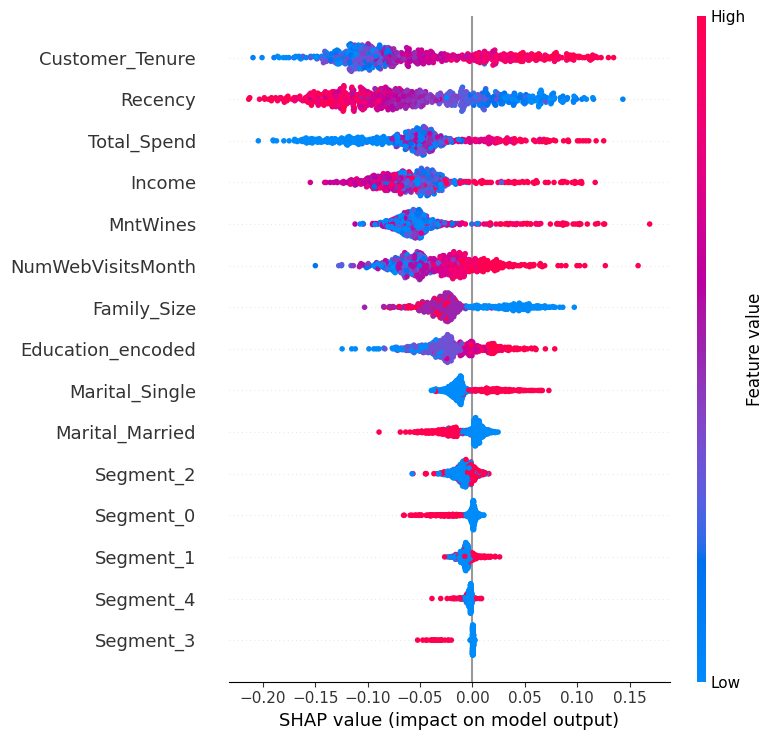

In [ ]:
# shap.initjs()  # Initialize JS visualization
# Generate SHAP values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Handle binary classification SHAP values
if isinstance(shap_values, list) and len(shap_values) == 2:
    # Binary classification case
    shap_values = shap_values[1]  # We want values for class 1 (positive response)
elif len(shap_values.shape) == 3:
    # Multi-class format, select class 1
    shap_values = shap_values[:, :, 1]

# Verify shapes match
assert shap_values.shape == X_test.shape, \
    f"SHAP values shape {shap_values.shape} doesn't match X_test shape {X_test.shape}"

#  Global Feature Importance (Matplotlib)
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Top Features Driving Campaign Response", fontsize=12)
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

# Use static instead of interactive visualization because it doesnot work
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')


In [14]:
# Bonus: Beeswarm Plot for Detailed Analysis
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Feature Impact on Campaign Response", fontsize=12)
plt.tight_layout()
plt.savefig('shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.close()

print("SHAP outputs saved successfully:")
print("- Global feature importance: shap_feature_importance.png")
print("- Detailed impact analysis: shap_beeswarm.png")

SHAP outputs saved successfully:
- Global feature importance: shap_feature_importance.png
- Detailed impact analysis: shap_beeswarm.png


## Response Probability by Segment

In [12]:
df['Response_Probability'] = best_rf.predict_proba(X)[:, 1]

# Visualize
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Cluster', 
    y='Response_Probability', 
    data=df,
    order=sorted(df['Cluster'].unique()),
    palette='viridis'
)
plt.title('Response Probability by Customer Segment', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Response Probability')
plt.xticks(ticks=range(len(df['Cluster'].unique())),
           labels=[f'Segment {i+1}' for i in sorted(df['Cluster'].unique())])
plt.savefig('response_by_segment.png', dpi=300, bbox_inches='tight')
plt.close()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18968\2887083304.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


## Save Results

In [13]:
# Save probabilities with cluster info
output_cols = ['ID', 'Cluster'] + features + ['Response_Probability']
df[output_cols].to_csv('customers_with_predictions.csv', index=False)

# Generate segment-level insights
segment_stats = df.groupby('Cluster')['Response_Probability'].agg(
    ['mean', 'median', 'std', 'count']
).reset_index()
segment_stats.columns = ['Segment', 'Avg_Prob', 'Median_Prob', 'Std_Prob', 'Count']
segment_stats.to_csv('segment_response_stats.csv', index=False)

print("\nOutput Files Created:")
print("- rf_model_with_segments.pkl: Trained model")
print("- shap_*.png: SHAP interpretation plots")
print("- response_by_segment.png: Segment comparison")
print("- customers_with_predictions.csv: Full dataset with predictions")
print("- segment_response_stats.csv: Summary statistics by segment")


Output Files Created:
- rf_model_with_segments.pkl: Trained model
- shap_*.png: SHAP interpretation plots
- response_by_segment.png: Segment comparison
- customers_with_predictions.csv: Full dataset with predictions
- segment_response_stats.csv: Summary statistics by segment
